# Dataset

Mount to Google Drive and define the path where the dataset will be

In [ ]:
from google.colab import drive

drive.mount("/content/drive", force_remount=True)
dataset_folder_path = '/content/drive/My Drive/Colab Notebooks/ML Research/supervised-learning/intelligent-locker-system'

If the dataset used by **Gesture6** is not found in the `dataset_folder_path`, connect to Kaggle, download it, and clean it.

In [ ]:
%pip install opendatasets --upgrade --quiet
%pip install tensorflow

In [ ]:
'''
USERNAME = pedrovillegascelis
KEY = 90f5d28b93ddc0dd614439c87078db60
'''

import opendatasets as od
import os

CLASSES = ["01_palm", "02_l", "04_fist_moved", "06_index", "07_ok", "08_palm_moved"] # Gesture6.1
download_path = os.path.join(dataset_folder_path, "data")

if not os.path.exists(download_path):
  od.download("https://www.kaggle.com/datasets/gti-upm/leapgestrecog/data", data_dir=download_path)

else:
  print("Dataset already downloaded")

In [ ]:
import shutil # Imported for directory removal -> the os.remove() is intended to remove files and not directories

data_path = "/content/drive/My Drive/Colab Notebooks/ML Research/supervised-learning/intelligent-locker-system/data/leapgestrecog/leapGestRecog"
for subject in os.listdir(data_path):
  for gesture in os.listdir(os.path.join(data_path, subject)):
    if gesture not in CLASSES:
      shutil.rmtree(os.path.join(data_path, subject, gesture))

In case of running locally.

In [1]:
import os
import shutil # Imported for directory removal -> the os.remove() is intended to remove files and not directories

CLASSES = ["01_palm", "02_l", "04_fist_moved", "06_index", "07_ok", "08_palm_moved"] # Gesture6.1

data_path = "data/leapgestrecog/leapGestRecog"
for subject in os.listdir(data_path):
  for gesture in os.listdir(os.path.join(data_path, subject)):
    if gesture not in CLASSES:
      shutil.rmtree(os.path.join(data_path, subject, gesture))

# Gesture6 224x224

Import the **model** dependencies.

In [4]:
import os
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout, Activation, LeakyReLU, GlobalAveragePooling2D
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import load_img, img_to_array

Function to get the file_paths and labels.

In [5]:
def get_file_paths_and_labels(data_path):
  file_paths = []
  labels = []

  CLASSES = ["01_palm", "02_l", "04_fist_moved", "06_index", "07_ok", "08_palm_moved"]

  label_map = {}
  for counter, gesture in enumerate(CLASSES):
    label_map[gesture] = counter
    # {'01_palm': 0, '02_l': 1, '04_fist_moved': 2, '06_index': 3, '07_ok': 4, '08_palm_moved': 5}

  for subject in os.listdir(data_path):
    subject_path = os.path.join(data_path, subject)

    for gesture in os.listdir(subject_path):
      gesture_path = os.path.join(subject_path, gesture)

      for img_file in os.listdir(gesture_path):
        file_path = os.path.join(gesture_path, img_file)
        file_paths.append(file_path)
        labels.append(label_map[gesture])

  return file_paths, labels

Get the file paths and labels (colab).

In [ ]:
data_path = "/content/drive/My Drive/Colab Notebooks/ML Research/supervised-learning/intelligent-locker-system/data/leapgestrecog/leapGestRecog"
file_paths, labels = get_file_paths_and_labels(data_path)

# This is done here also, outside the previous function, just to have the "label_map" saved globally in case of a need.
CLASSES = ["01_palm", "02_l", "04_fist_moved", "06_index", "07_ok", "08_palm_moved"]
label_map = {}
for counter, gesture in enumerate(CLASSES):
  label_map[gesture] = counter

print("Label map:", label_map)

Get the file paths and labels (local).

In [6]:
data_path = "data/leapgestrecog/leapGestRecog"
file_paths, labels = get_file_paths_and_labels(data_path)

# This is done here also, outside the previous function, just to have the "label_map" saved globally in case of a need.
CLASSES = ["01_palm", "02_l", "04_fist_moved", "06_index", "07_ok", "08_palm_moved"]
label_map = {}
for counter, gesture in enumerate(CLASSES):
  label_map[gesture] = counter

print("Label map:", label_map)

Label map: {'01_palm': 0, '02_l': 1, '04_fist_moved': 2, '06_index': 3, '07_ok': 4, '08_palm_moved': 5}


Shuffle the data

In [7]:
'''
- "file_paths" is a list that contains the path to each image in the dataset
- "labels" is a list that contains the label of each image in the dataset

If file_paths is ['image1.jpg', 'image2.jpg'] and labels is [0, 1], after list(zip(...))
data will be [('image1.jpg', 0), ('image2.jpg', 1)].
'''
data = list(zip(file_paths, labels))

# Shuffle the data to improve training by randomizing
# the order of image-label pairs.
np.random.shuffle(data)

# Once the data has been randomized, zip(*data) undo the previous operations
# in the lists file_paths and labels to keep everything the same as before.
file_paths, labels = zip(*data)

Convert labels to string.

In [8]:
labels_str = [str(label) for label in labels]

Create a dataframe with file_paths and labels_str to finally create the ImageDataGenerator for training and validation.

In [9]:
# pd.DataFrame({column_name: values})

dataframe = pd.DataFrame({'filename': file_paths, 'class': labels_str})
dataframe

,filename,class
0,data/leapgestrecog/leapGestRecog\06\07_ok\fram...,4
1,data/leapgestrecog/leapGestRecog\01\06_index\f...,3
2,data/leapgestrecog/leapGestRecog\05\02_l\frame...,1
3,data/leapgestrecog/leapGestRecog\01\08_palm_mo...,5
4,data/leapgestrecog/leapGestRecog\06\02_l\frame...,1
...,...,...
11995,data/leapgestrecog/leapGestRecog\02\02_l\frame...,1
11996,data/leapgestrecog/leapGestRecog\05\06_index\f...,3
11997,data/leapgestrecog/leapGestRecog\01\06_index\f...,3
11998,data/leapgestrecog/leapGestRecog\09\08_palm_mo...,5


Parameters.

In [10]:
batch_size = 32
num_classes = 6
learning_rate = 0.001
epochs = 2
img_size = 224

Create ImageDataGenerator for training and validation.

In [11]:
datagen = ImageDataGenerator(
    rescale=1/255.0,            # Normalization
    # zoom_range=0.2,             # Data Aug.
    # width_shift_range=0.2,      # Data Aug.
    # height_shift_range=0.2,     # Data Aug.
    validation_split=0.2        # 20% of the data for validation
)

train_generator = datagen.flow_from_dataframe(
    dataframe=dataframe,
    x_col='filename',
    y_col='class',
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

validation_generator = datagen.flow_from_dataframe(
    dataframe=dataframe,
    x_col='filename',
    y_col='class',
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)

Found 9600 validated image filenames belonging to 6 classes.
Found 2400 validated image filenames belonging to 6 classes.


Define the model.

In [12]:
model = Sequential()

model.add(Input(shape=(img_size, img_size, 3)))
model.add(Conv2D(filters=8, kernel_size=(3,3)))
model.add(Activation('relu'))

model.add(Conv2D(filters=8, kernel_size=(3,3)))
model.add(Activation('relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.3))

model.add(Conv2D(filters=16, kernel_size=(3,3)))
model.add(Activation('relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.3))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))

model.compile(
    loss='categorical_crossentropy',
    optimizer='Adam',
    metrics=['accuracy']
)


In [13]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 8)    │           224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 222, 222, 8)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 220, 220, 8)    │           584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 220, 220, 8)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 110, 110, 8)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 110, 110, 8)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 108, 108, 16)   │         1,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 108, 108, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 54, 54, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 46656)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     5,972,096 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,974,846 (22.79 MB)

 Trainable params: 5,974,846 (22.79 MB)

 Non-trainable params: 0 (0.00 B)

Define EarlyStopping before training.

*`EarlyStopping` is a Keras callback used to stop model training early if performance on a monitored metric, like validation loss (`val_loss`), stops improving. With `patience=3`, training stops if the metric doesn't improve for 3 consecutive epochs. The `restore_best_weights=True` option ensures the model retains the best weights found during training. This approach helps prevent overfitting, saves computational resources, and ensures better generalization on unseen data. It's particularly useful for optimizing training time while maintaining model quality.*

In [14]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

Train the model with early stopping

In [15]:
history = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=validation_generator,
    callbacks=[early_stopping]
)

c:\Users\pablo\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/2
300/300 ━━━━━━━━━━━━━━━━━━━━ 78s 251ms/step - accuracy: 0.7685 - loss: 0.7213 - val_accuracy: 0.9954 - val_loss: 0.0234
Epoch 2/2
300/300 ━━━━━━━━━━━━━━━━━━━━ 72s 239ms/step - accuracy: 0.9972 - loss: 0.0087 - val_accuracy: 0.9967 - val_loss: 0.0098


In [17]:
history.history

{'accuracy': [0.9131249785423279, 0.9962499737739563],
 'loss': [0.2787262201309204, 0.010173418559134007],
 'val_accuracy': [0.9954166412353516, 0.996666669845581],
 'val_loss': [0.023387426510453224, 0.009793403558433056]}

Plot the training history.

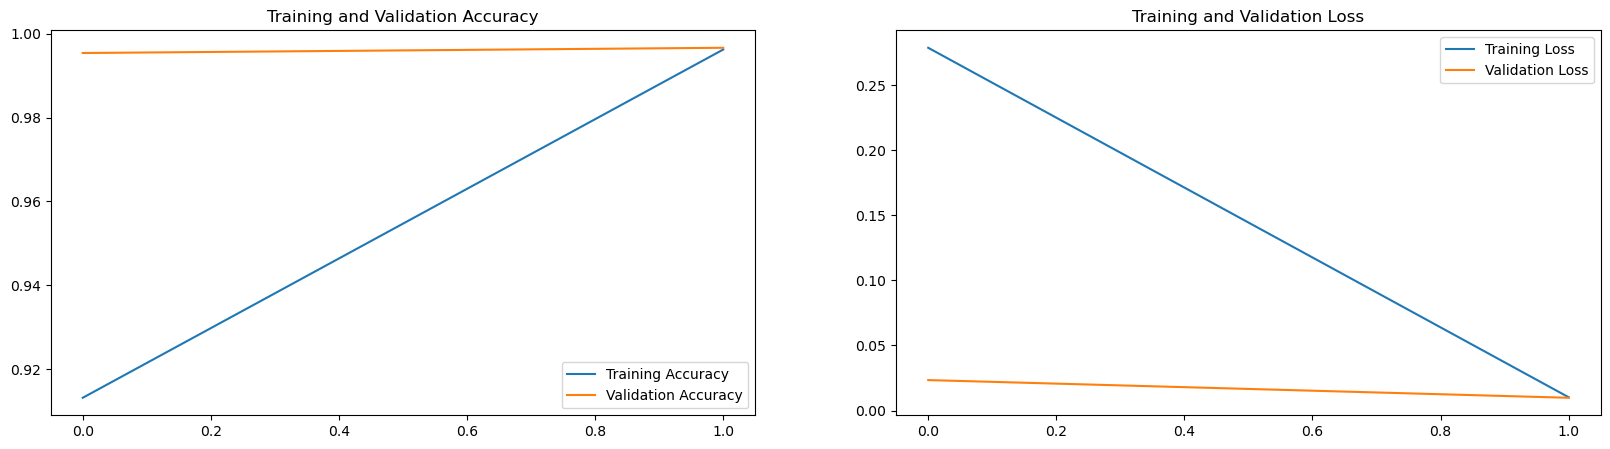

In [18]:
def plot_training_history(history):
  training_accuracy = history.history['accuracy']
  training_loss = history.history['loss']

  validation_accuracy = history.history['val_accuracy']
  validation_loss = history.history['val_loss']

  epochs_range = range(len(training_accuracy))

  # Main figure size (20,5)
  plt.figure(figsize=(20,5))

  # First subplot (Accuracy)
  plt.subplot(1,2,1) # plt.subplot(n_rows, n_cols, pos)
  plt.plot(epochs_range, training_accuracy, label='Training Accuracy')
  plt.plot(epochs_range, validation_accuracy, label='Validation Accuracy')
  plt.legend(loc='lower right')
  plt.title('Training and Validation Accuracy')

  # Second subplot (Loss)
  plt.subplot(1,2,2)
  plt.plot(epochs_range, training_loss, label='Training Loss')
  plt.plot(epochs_range, validation_loss, label='Validation Loss')
  plt.legend(loc='upper right')
  plt.title('Training and Validation Loss')
  plt.show()

plot_training_history(history)

Evaluate the model.

In [19]:
validation_loss, validation_accuracy = model.evaluate(validation_generator)
print(f"Validation Loss: {validation_loss}")
print(f"Validation Accuracy: {validation_accuracy}")

75/75 ━━━━━━━━━━━━━━━━━━━━ 9s 123ms/step - accuracy: 0.9970 - loss: 0.0086
Validation Loss: 0.009793401695787907
Validation Accuracy: 0.996666669845581


Save the model (colab).

In [ ]:
model_path = "/content/drive/My Drive/Colab Notebooks/ML Research/supervised-learning/intelligent-locker-system"
model.save(os.path.join(model_path, 'Gesture6_11MB.h5'))

Save the model (local).

In [23]:
model_path = "C:/Users/pablo/Desktop/Gesture6/Gesture6/models"
model.save(os.path.join(model_path, 'Gesture6_11MB_99ACC.h5'))

# Gesture6 96x96 (local procedure)

In [46]:
import os
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout, Activation, LeakyReLU, GlobalAveragePooling2D
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import load_img, img_to_array

Reshape the original images from 224x224 to 96x96. This creates a new dataset called `data_reshaped`.

In [49]:
import os
from PIL import Image

data_path = "data/leapgestrecog/leapGestRecog"
data_reshaped_path = "data_reshaped"

# MKDIR if data_reshaped is not found
os.makedirs(data_reshaped_path, exist_ok=True)

for subject in os.listdir(data_path):
    subject_reshaped_path = os.path.join(data_reshaped_path, subject)
    os.makedirs(subject_reshaped_path, exist_ok=True)

    for gesture in os.listdir(os.path.join(data_path, subject)):
        gesture_reshaped_path = os.path.join(subject_reshaped_path, gesture)
        os.makedirs(gesture_reshaped_path, exist_ok=True)

        for img_file in os.listdir(os.path.join(data_path, subject, gesture)):
            img_path = os.path.join(data_path, subject, gesture, img_file)
            img_reshaped_path = os.path.join(gesture_reshaped_path, img_file)

            img = Image.open(img_path)
            img = img.resize((96, 96))
            img.save(img_reshaped_path)

print("The 96x96 version of the original images were saved in:", data_reshaped_path)

The 96x96 version of the original images were saved in: data_reshaped


Get the file_paths and labels.

In [50]:
def get_file_paths_and_labels(data_path):
  file_paths = []
  labels = []

  CLASSES = ["01_palm", "02_l", "04_fist_moved", "06_index", "07_ok", "08_palm_moved"]

  label_map = {}
  for counter, gesture in enumerate(CLASSES):
    label_map[gesture] = counter
    # {'01_palm': 0, '02_l': 1, '04_fist_moved': 2, '06_index': 3, '07_ok': 4, '08_palm_moved': 5}

  for subject in os.listdir(data_path):
    subject_path = os.path.join(data_path, subject)

    for gesture in os.listdir(subject_path):
      gesture_path = os.path.join(subject_path, gesture)

      for img_file in os.listdir(gesture_path):
        file_path = os.path.join(gesture_path, img_file)
        file_paths.append(file_path)
        labels.append(label_map[gesture])

  return file_paths, labels

In [51]:
data_path = data_reshaped_path
file_paths, labels = get_file_paths_and_labels(data_path)

# This is done here also, outside the previous function, just to have the "label_map" saved globally in case of a need.
CLASSES = ["01_palm", "02_l", "04_fist_moved", "06_index", "07_ok", "08_palm_moved"]
label_map = {}
for counter, gesture in enumerate(CLASSES):
  label_map[gesture] = counter

print("Label map:", label_map)

Label map: {'01_palm': 0, '02_l': 1, '04_fist_moved': 2, '06_index': 3, '07_ok': 4, '08_palm_moved': 5}


Shuffle the data.

In [52]:
'''
- "file_paths" is a list that contains the path to each image in the dataset
- "labels" is a list that contains the label of each image in the dataset

If file_paths is ['image1.jpg', 'image2.jpg'] and labels is [0, 1], after list(zip(...))
data will be [('image1.jpg', 0), ('image2.jpg', 1)].
'''
data = list(zip(file_paths, labels))

# Shuffle the data to improve training by randomizing
# the order of image-label pairs.
np.random.shuffle(data)

# Once the data has been randomized, zip(*data) undo the previous operations
# in the lists file_paths and labels to keep everything the same as before.
file_paths, labels = zip(*data)

Convert labels to string.

In [53]:
labels_str = [str(label) for label in labels]

Create a dataframe with file_paths and labels_str to finally create the ImageDataGenerator for training and validation.

In [54]:
# pd.DataFrame({column_name: values})

dataframe = pd.DataFrame({'filename': file_paths, 'class': labels_str})
dataframe

,filename,class
0,data_reshaped\01\02_l\frame_01_02_0107.png,1
1,data_reshaped\03\01_palm\frame_03_01_0064.png,0
2,data_reshaped\04\08_palm_moved\frame_04_08_008...,5
3,data_reshaped\06\07_ok\frame_06_07_0147.png,4
4,data_reshaped\01\06_index\frame_01_06_0142.png,3
...,...,...
11995,data_reshaped\01\06_index\frame_01_06_0157.png,3
11996,data_reshaped\06\08_palm_moved\frame_06_08_006...,5
11997,data_reshaped\00\08_palm_moved\frame_00_08_004...,5
11998,data_reshaped\07\06_index\frame_07_06_0163.png,3


Parameters.

In [59]:
batch_size = 32
num_classes = 6
learning_rate = 0.001
epochs = 30
img_size = 96

Create the ImageDataGenerator for training and validation.

In [56]:
datagen = ImageDataGenerator(
    rescale=1/255.0,            # Normalization
    zoom_range=0.2,             # Data Aug.
    width_shift_range=0.2,      # Data Aug.
    height_shift_range=0.2,     # Data Aug.
    validation_split=0.2        # 20% of the data for validation
)

train_generator = datagen.flow_from_dataframe(
    dataframe=dataframe,
    x_col='filename',
    y_col='class',
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

validation_generator = datagen.flow_from_dataframe(
    dataframe=dataframe,
    x_col='filename',
    y_col='class',
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)

Found 9600 validated image filenames belonging to 6 classes.
Found 2400 validated image filenames belonging to 6 classes.


Define the model.

In [57]:
model = Sequential()

model.add(Input(shape=(img_size, img_size, 3)))
model.add(Conv2D(filters=8, kernel_size=(3,3)))
model.add(Activation('relu'))

model.add(Conv2D(filters=8, kernel_size=(3,3)))
model.add(Activation('relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.3))

model.add(Conv2D(filters=16, kernel_size=(3,3)))
model.add(Activation('relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.3))

model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))

model.compile(
    loss='categorical_crossentropy',
    optimizer='Adam',
    metrics=['accuracy']
)

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 94, 94, 8)      │           224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 94, 94, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 92, 92, 8)      │           584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 92, 92, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 46, 46, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 46, 46, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 44, 44, 16)     │         1,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 44, 44, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 22, 22, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 22, 22, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 7744)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │       495,680 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │           390 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 498,046 (1.90 MB)

 Trainable params: 498,046 (1.90 MB)

 Non-trainable params: 0 (0.00 B)

Define EarlyStopping before training.

*`EarlyStopping` is a Keras callback used to stop model training early if performance on a monitored metric, like validation loss (`val_loss`), stops improving. With `patience=3`, training stops if the metric doesn't improve for 3 consecutive epochs. The `restore_best_weights=True` option ensures the model retains the best weights found during training. This approach helps prevent overfitting, saves computational resources, and ensures better generalization on unseen data. It's particularly useful for optimizing training time while maintaining model quality.*

In [60]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

Train the model with early stopping.

In [61]:
history = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=validation_generator,
    callbacks=[early_stopping]
)

c:\Users\pablo\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
300/300 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - accuracy: 0.3223 - loss: 1.5845

c:\Users\pablo\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


300/300 ━━━━━━━━━━━━━━━━━━━━ 47s 149ms/step - accuracy: 0.3228 - loss: 1.5836 - val_accuracy: 0.7479 - val_loss: 0.7217
Epoch 2/30
300/300 ━━━━━━━━━━━━━━━━━━━━ 45s 148ms/step - accuracy: 0.7866 - loss: 0.5841 - val_accuracy: 0.9046 - val_loss: 0.3022
Epoch 3/30
300/300 ━━━━━━━━━━━━━━━━━━━━ 54s 178ms/step - accuracy: 0.8861 - loss: 0.3184 - val_accuracy: 0.9229 - val_loss: 0.2254
Epoch 4/30
300/300 ━━━━━━━━━━━━━━━━━━━━ 46s 153ms/step - accuracy: 0.9260 - loss: 0.2224 - val_accuracy: 0.9629 - val_loss: 0.1253
Epoch 5/30
300/300 ━━━━━━━━━━━━━━━━━━━━ 44s 148ms/step - accuracy: 0.9466 - loss: 0.1645 - val_accuracy: 0.9538 - val_loss: 0.1367
Epoch 6/30
300/300 ━━━━━━━━━━━━━━━━━━━━ 45s 149ms/step - accuracy: 0.9596 - loss: 0.1217 - val_accuracy: 0.9717 - val_loss: 0.1022
Epoch 7/30
300/300 ━━━━━━━━━━━━━━━━━━━━ 46s 152ms/step - accuracy: 0.9692 - loss: 0.0957 - val_accuracy: 0.9800 - val_loss: 0.0718
Epoch 8/30
300/300 ━━━━━━━━━━━━━━━━━━━━ 45s 149ms/step - accuracy: 0.9661 - loss: 0.1014 - val

Plot the training history.

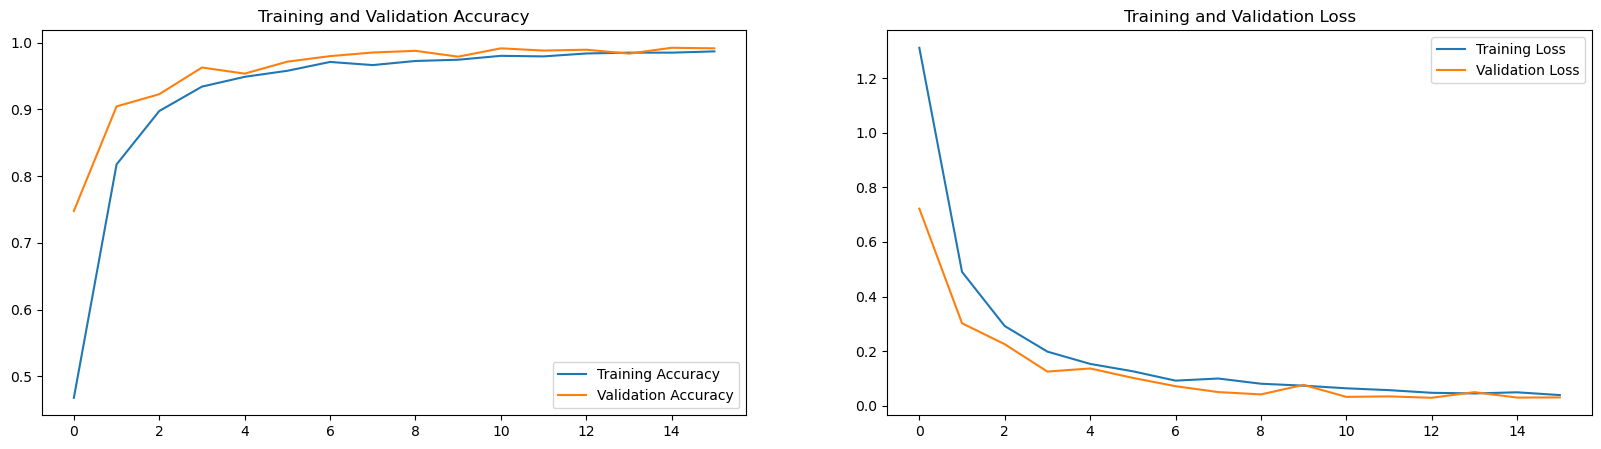

In [62]:
def plot_training_history(history):
  training_accuracy = history.history['accuracy']
  training_loss = history.history['loss']

  validation_accuracy = history.history['val_accuracy']
  validation_loss = history.history['val_loss']

  epochs_range = range(len(training_accuracy))

  # Main figure size (20,5)
  plt.figure(figsize=(20,5))

  # First subplot (Accuracy)
  plt.subplot(1,2,1) # plt.subplot(n_rows, n_cols, pos)
  plt.plot(epochs_range, training_accuracy, label='Training Accuracy')
  plt.plot(epochs_range, validation_accuracy, label='Validation Accuracy')
  plt.legend(loc='lower right')
  plt.title('Training and Validation Accuracy')

  # Second subplot (Loss)
  plt.subplot(1,2,2)
  plt.plot(epochs_range, training_loss, label='Training Loss')
  plt.plot(epochs_range, validation_loss, label='Validation Loss')
  plt.legend(loc='upper right')
  plt.title('Training and Validation Loss')
  plt.show()

plot_training_history(history)

Evaluate the model.

In [63]:
validation_loss, validation_accuracy = model.evaluate(validation_generator)
print(f"Validation Loss: {validation_loss}")
print(f"Validation Accuracy: {validation_accuracy}")

75/75 ━━━━━━━━━━━━━━━━━━━━ 9s 123ms/step - accuracy: 0.9935 - loss: 0.0263
Validation Loss: 0.02813723310828209
Validation Accuracy: 0.9920833110809326


0


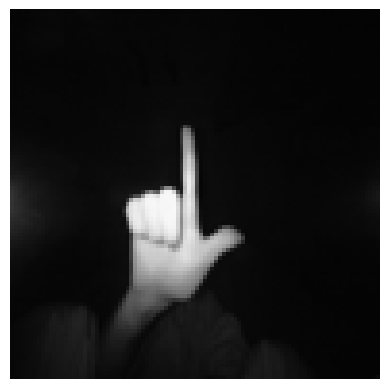

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step
La clase predicha para la imagen es: 02_l
1


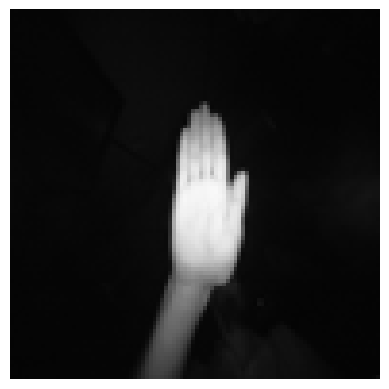

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
La clase predicha para la imagen es: 01_palm
2


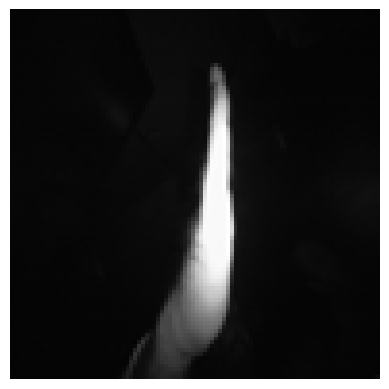

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
La clase predicha para la imagen es: 08_palm_moved
3


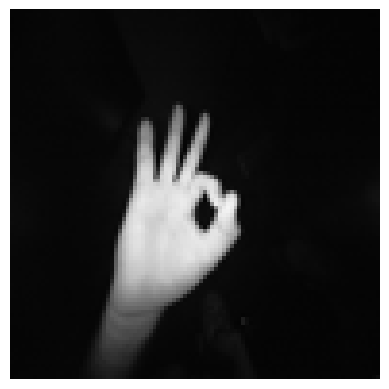

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
La clase predicha para la imagen es: 07_ok
4


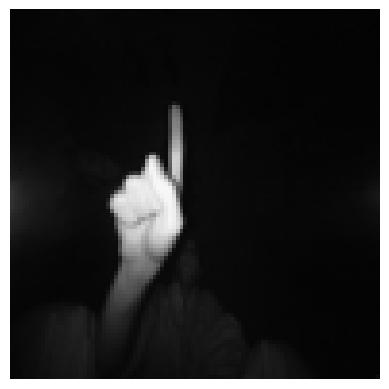

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
La clase predicha para la imagen es: 06_index
5


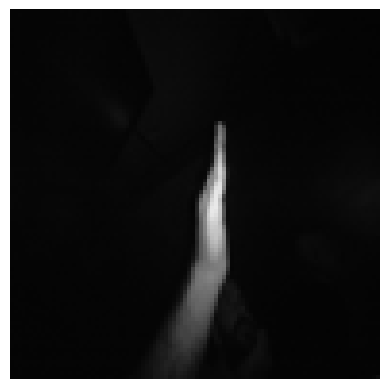

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
La clase predicha para la imagen es: 08_palm_moved
6


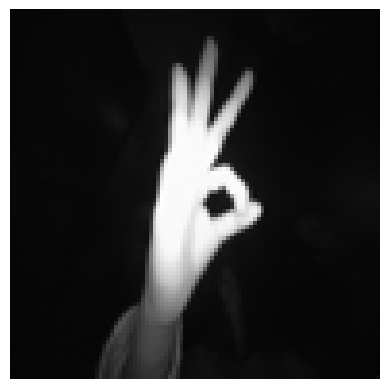

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
La clase predicha para la imagen es: 07_ok
7


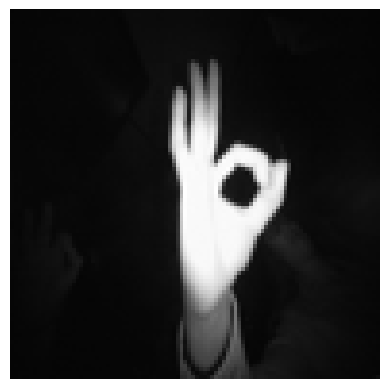

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
La clase predicha para la imagen es: 07_ok
8


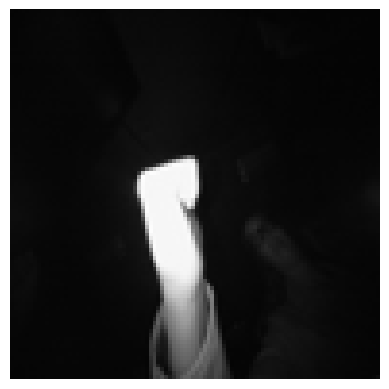

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
La clase predicha para la imagen es: 04_fist_moved
9


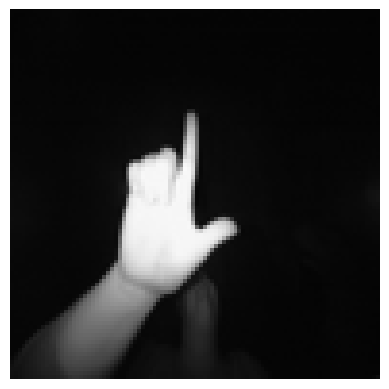

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
La clase predicha para la imagen es: 02_l
10


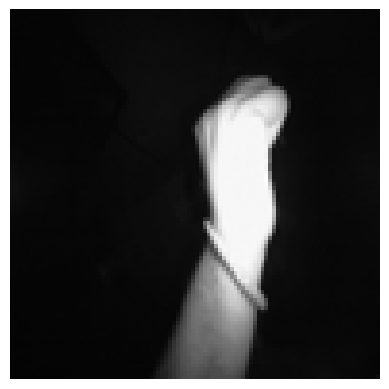

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
La clase predicha para la imagen es: 04_fist_moved
11


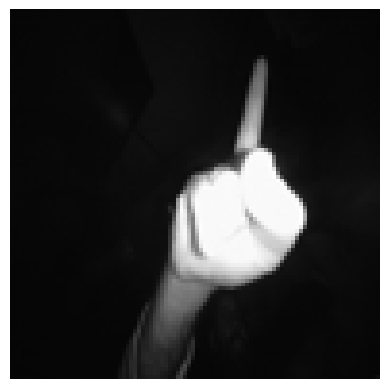

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
La clase predicha para la imagen es: 06_index
12


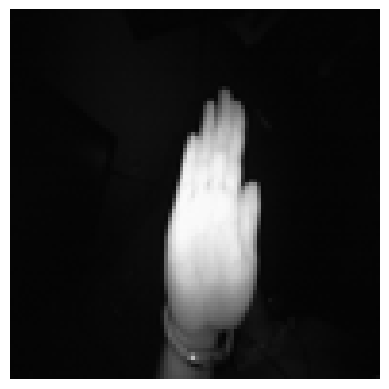

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
La clase predicha para la imagen es: 01_palm
13


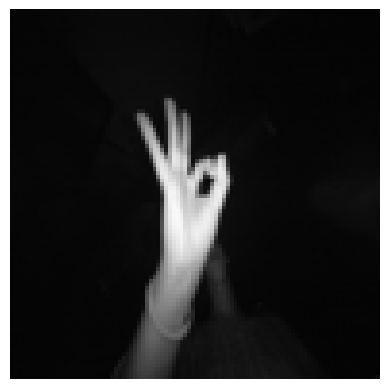

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
La clase predicha para la imagen es: 07_ok
14


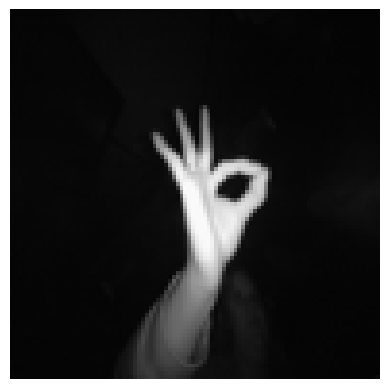

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
La clase predicha para la imagen es: 07_ok


In [64]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image

def preprocess_and_show_image(img_path, target_size=(96, 96)):
    img = image.load_img(img_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  
    img_array = img_array / 255.0 

    plt.imshow(img)
    plt.axis('off') 
    plt.show()
    return img_array

def predict_image(model, img_path):
    preprocessed_image = preprocess_and_show_image(img_path)
    prediction = model.predict(preprocessed_image)
    predicted_class = np.argmax(prediction, axis=1)
    return predicted_class


for idx, img in enumerate(file_paths[:15]):
    print(idx)
    img_path = file_paths[idx] 
    predicted_class = predict_image(model, img_path)
    print(f'La clase predicha para la imagen es: {next((key for key, val in label_map.items() if val == predicted_class[0]), None)}')

Save the model.

In [65]:
model_path = "C:/Users/pablo/Desktop/Gesture6/Gesture6/models"
model.save(os.path.join(model_path, 'Gesture6_2MB_96X96.keras'))

### Post Training Quantization.

In [66]:
def representative_data_gen():
    for _ in range(100):  # Ajusta la cantidad de muestras representativas si es necesario
        # Obtén un lote de imágenes del generador
        image_batch, _ = next(train_generator)  # Ignoramos las etiquetas
        # Selecciona la primera imagen del lote y asegúrate de que coincida con la forma esperada del modelo
        sample = image_batch[0:1]  # Selecciona solo una imagen con forma [1, img_size, img_size, 3]
        yield [sample.astype(np.float32)]

# Configurar el convertidor para la cuantización
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_data_gen
# Asegurarse de que las operaciones que no pueden ser cuantizadas lancen un error
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
# Establecer las entradas y salidas a uint8
converter.inference_input_type = tf.uint8
converter.inference_output_type = tf.uint8

# Convertir el modelo cuantizado
tflite_model_quant = converter.convert()

# Guardar el modelo convertido
with open('quant_model_uint8.tflite', 'wb') as f:
    f.write(tflite_model_quant)


INFO:tensorflow:Assets written to: C:\Users\pablo\AppData\Local\Temp\tmp5okm4buu\assets


INFO:tensorflow:Assets written to: C:\Users\pablo\AppData\Local\Temp\tmp5okm4buu\assets


Saved artifact at 'C:\Users\pablo\AppData\Local\Temp\tmp5okm4buu'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 96, 96, 3), dtype=tf.float32, name='keras_tensor_455')
Output Type:
  TensorSpec(shape=(None, 6), dtype=tf.float32, name=None)
Captures:
  2203888534736: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2203888535120: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2203888534928: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2203888536272: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2203888536464: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2203888537424: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2203888535696: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2203888538960: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2203888536656: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2203888539536: TensorSpec(shape=(), dtype=tf.resource, name=None)


c:\Users\pablo\anaconda3\Lib\site-packages\tensorflow\lite\python\convert.py:983: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(


In [ ]:
!xxd -i model.tflite > model.cc

TFLite Interpreter.

In [67]:
import os

def get_file_paths_and_labels(data_path):
  file_paths = []
  labels = []

  CLASSES = ["01_palm", "02_l", "04_fist_moved", "06_index", "07_ok", "08_palm_moved"]

  label_map = {}
  for counter, gesture in enumerate(CLASSES):
    label_map[gesture] = counter
    # {'01_palm': 0, '02_l': 1, '04_fist_moved': 2, '06_index': 3, '07_ok': 4, '08_palm_moved': 5}

  for subject in os.listdir(data_path):
    subject_path = os.path.join(data_path, subject)

    for gesture in os.listdir(subject_path):
      gesture_path = os.path.join(subject_path, gesture)

      for img_file in os.listdir(gesture_path):
        file_path = os.path.join(gesture_path, img_file)
        file_paths.append(file_path)
        labels.append(label_map[gesture])

  return file_paths, labels

data_path = "data_reshaped"
file_paths, labels = get_file_paths_and_labels(data_path)

CLASSES = ["01_palm", "02_l", "04_fist_moved", "06_index", "07_ok", "08_palm_moved"]
label_map = {}
for counter, gesture in enumerate(CLASSES):
  label_map[gesture] = counter

print("Label map:", label_map)

Label map: {'01_palm': 0, '02_l': 1, '04_fist_moved': 2, '06_index': 3, '07_ok': 4, '08_palm_moved': 5}


In [68]:
data = list(zip(file_paths, labels))
np.random.shuffle(data)
file_paths, labels = zip(*data)

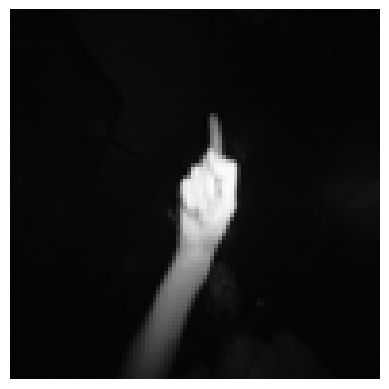

La clase predicha para la imagen es: 06_index


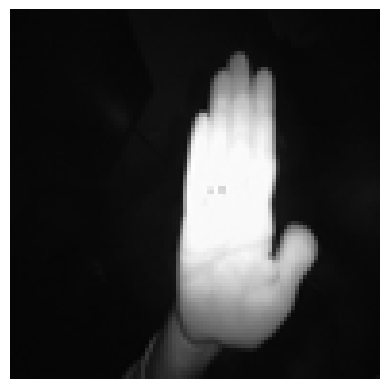

La clase predicha para la imagen es: 01_palm


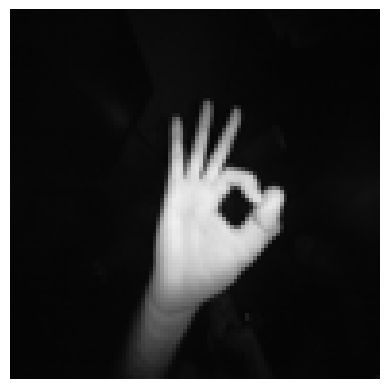

La clase predicha para la imagen es: 07_ok


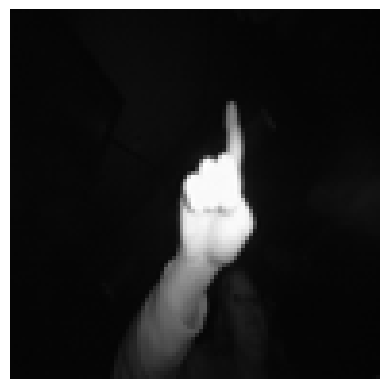

La clase predicha para la imagen es: 06_index


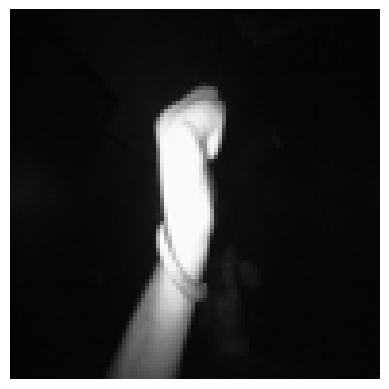

La clase predicha para la imagen es: 04_fist_moved


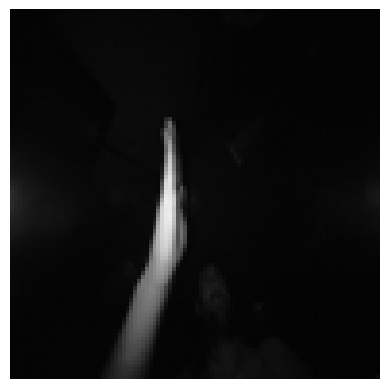

La clase predicha para la imagen es: 08_palm_moved


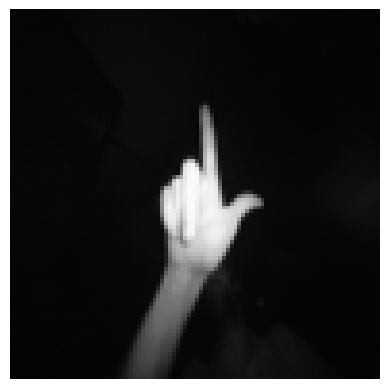

La clase predicha para la imagen es: 02_l


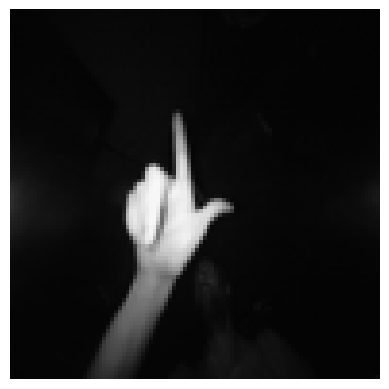

La clase predicha para la imagen es: 02_l


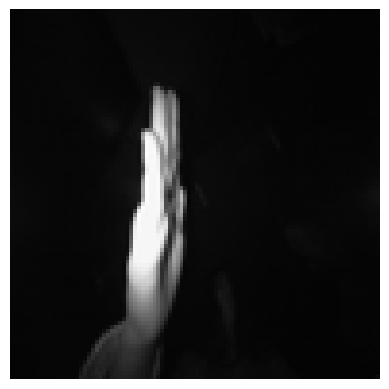

La clase predicha para la imagen es: 08_palm_moved


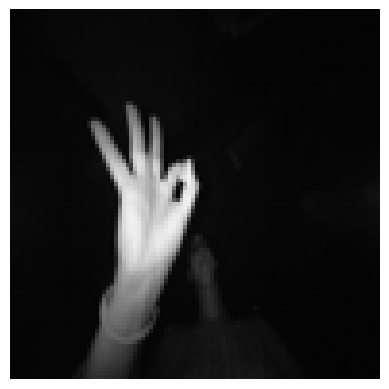

La clase predicha para la imagen es: 07_ok


In [72]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image

# Preprocesar la imagen y mostrarla
def preprocess_and_show_image(img_path, target_size=(96, 96)):
    img = image.load_img(img_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  
    
    # Escalar los valores a 0-255 y convertir a uint8
    img_array = np.clip(img_array, 0, 255).astype(np.uint8)

    plt.imshow(img)
    plt.axis('off') 
    plt.show()
    return img_array

# Función para realizar predicción con el modelo cuantizado
def predict_image_tflite(interpreter, img_path):
    preprocessed_image = preprocess_and_show_image(img_path)

    # Obtener detalles de entrada y salida
    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()

    # Configurar el tensor de entrada
    interpreter.set_tensor(input_details[0]['index'], preprocessed_image)

    # Ejecutar la inferencia
    interpreter.invoke()

    # Obtener la salida del modelo
    output_data = interpreter.get_tensor(output_details[0]['index'])

    # Obtener la clase predicha
    predicted_class = np.argmax(output_data, axis=1)
    return predicted_class

# Cargar el modelo cuantizado
interpreter = tf.lite.Interpreter(model_path='quantized_models/quant_model_uint8.tflite')
interpreter.allocate_tensors()

# Predecir las primeras 15 imágenes
for idx, img in enumerate(file_paths[15:25]):
    img_path = file_paths[idx]
    predicted_class = predict_image_tflite(interpreter, img_path)
    # Obtener la etiqueta correspondiente a la clase predicha
    class_name = next((key for key, val in label_map.items() if val == predicted_class[0]), None)
    print(f'La clase predicha para la imagen es: {class_name}')
